# Adversarial machine learning - classical models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Dataset

In [3]:
digits = [3, 5, 8, 9]
n_px = 16

train_size = 10000
test_size = 2000

batch_size = 64
epochs = 20

In [4]:
def get_dataset(digits=[3, 5], n_px=8, train_size=1000, test_size=200):
    # Load raw data (uint8 [0-255])
    mnist_train = datasets.MNIST(root='./data', train=True, download=True)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True)

    # Helper: filter, sample, normalize, resize
    def prepare(data, targets, digits, size, n_px):
        # Filter by class
        mask = torch.zeros_like(targets, dtype=torch.bool)
        for d in digits:
            mask |= (targets == d)
        data_f = data[mask]
        targ_f = targets[mask]

        # Sample 'size' examples
        idx = torch.randperm(len(data_f))[:size]
        imgs = data_f[idx].unsqueeze(1).float() / 255.0  # [size,1,28,28]
        labs = targ_f[idx]

        # Resize to n_px x n_px
        imgs_resized = F.interpolate(imgs, size=(n_px, n_px), mode='bilinear', align_corners=False)
        # Map labels to 0..len(digits)-1
        labs_mapped = torch.tensor([digits.index(int(l)) for l in labs])
        return imgs_resized, labs_mapped

    x_train, y_train = prepare(mnist_train.data, mnist_train.targets, digits, train_size, n_px)
    x_test, y_test   = prepare(mnist_test.data, mnist_test.targets,   digits, test_size,  n_px)
    return (x_train, y_train), (x_test, y_test)

In [5]:
# Load and prepare dataset
(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px, train_size=train_size, test_size=test_size)
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test,  y_test),  batch_size=batch_size)

### Visulaise data

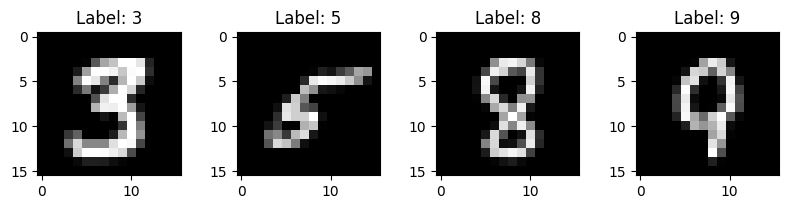

In [6]:
# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_train[y_train == i])[0].squeeze(0) for i in range(len(digits))]
y_vis = digits

# later when we train the model we include the predictions as well, so let's just add the functionality here
def visualize_data(x, y, pred=None):
    n_img = len(x)
    fig, axes = plt.subplots(1, n_img, figsize=(2*n_img, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(y[i]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(y[i], pred[i]))
    plt.tight_layout(w_pad=2)
    # plt.show()

visualize_data(x_vis, y_vis)

## Classical models

In [7]:
# convolutional neural network for good performance
# PyTorch tutorials: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class NetCNN(nn.Module):
    def __init__(self, n_px, n_classes):
        super().__init__()
        # out_size = [w-k+2p]/s+1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * n_px//4 * n_px//4, 16)
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# fully connected neural network for direct comparison with quantum model
# PyTorch tutorials: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html
class NeuralNetwork(nn.Module):
    def __init__(self, n_px, n_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_px*n_px, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, n_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
neural_model = NeuralNetwork(n_px=16, n_classes=4).to(device)
summary(neural_model,input_size=(1,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 256]               0
            Linear-2                   [-1, 32]           8,224
              ReLU-3                   [-1, 32]               0
            Linear-4                    [-1, 8]             264
              ReLU-5                    [-1, 8]               0
            Linear-6                    [-1, 4]              36
Total params: 8,524
Trainable params: 8,524
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [9]:
cnn_model = NetCNN(n_px=16, n_classes=4).to(device)
summary(cnn_model,input_size=(1,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 16, 16]              80
         MaxPool2d-2              [-1, 8, 8, 8]               0
            Conv2d-3             [-1, 16, 8, 8]           1,168
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                   [-1, 16]           4,112
            Linear-6                    [-1, 4]              68
Total params: 5,428
Trainable params: 5,428
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


### Training

In [10]:
# def train_loop(dataloader, model, loss_fn, optimizer, device):
#     size = len(dataloader.dataset)
#     # Set the model to training mode - important for batch normalization and dropout layers
#     # Unnecessary in this situation but added for best practices
#     model.train()
#     for batch, (X, y) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
#         X, y = X.to(device), y.to(device)
#         # Compute prediction and loss
#         pred = model(X)
#         loss = loss_fn(pred, y)

#         # Backpropagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * batch_size + len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


# def test_loop(dataloader, model, loss_fn, device):
#     # Set the model to evaluation mode - important for batch normalization and dropout layers
#     # Unnecessary in this situation but added for best practices
#     model.eval()
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss, correct = 0, 0

#     # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
#     # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
#     with torch.no_grad():
#         for X, y in dataloader:
#             X, y = X.to(device), y.to(device)
#             pred = model(X)
#             test_loss += loss_fn(pred, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

#     test_loss /= num_batches
#     correct /= size
#     print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    loop = tqdm(dataloader, desc="Train", leave=False)
    for X, y in loop:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            total_loss += loss_fn(pred, y).item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
neural_model = NeuralNetwork(n_px=n_px, n_classes=len(digits)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(neural_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_loop(train_loader, neural_model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_loader, neural_model, loss_fn, device)
    print(f"Epoch {epoch:2d}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:5.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:5.2f}%")

Epoch  1/20 | Train Loss: 0.9400 | Train Acc: 66.51% | Test Loss: 0.4234 | Test Acc: 90.05%


Epoch  2/20 | Train Loss: 0.3111 | Train Acc: 90.70% | Test Loss: 0.2497 | Test Acc: 92.25%


Epoch  3/20 | Train Loss: 0.2303 | Train Acc: 92.60% | Test Loss: 0.2255 | Test Acc: 93.00%


Epoch  4/20 | Train Loss: 0.2026 | Train Acc: 93.44% | Test Loss: 0.2105 | Test Acc: 93.80%


Epoch  5/20 | Train Loss: 0.1873 | Train Acc: 93.95% | Test Loss: 0.1960 | Test Acc: 93.90%


Epoch  6/20 | Train Loss: 0.1719 | Train Acc: 94.49% | Test Loss: 0.1901 | Test Acc: 94.35%


Epoch  7/20 | Train Loss: 0.1621 | Train Acc: 94.71% | Test Loss: 0.1824 | Test Acc: 94.10%


Epoch  8/20 | Train Loss: 0.1532 | Train Acc: 95.09% | Test Loss: 0.1718 | Test Acc: 94.80%


Epoch  9/20 | Train Loss: 0.1464 | Train Acc: 95.16% | Test Loss: 0.1707 | Test Acc: 94.90%


Epoch 10/20 | Train Loss: 0.1395 | Train Acc: 95.53% | Test Loss: 0.1620 | Test Acc: 94.95%


Epoch 11/20 | Train Loss: 0.1344 | Train Acc: 95.63% | Test Loss: 0.1604 | Test Acc: 95.10%


Epoch 12/20 | Train Loss: 0.1302 | Train Acc: 95.67% | Test Loss: 0.1593 | Test Acc: 95.10%


Epoch 13/20 | Train Loss: 0.1228 | Train Acc: 96.06% | Test Loss: 0.1558 | Test Acc: 95.20%


Epoch 14/20 | Train Loss: 0.1187 | Train Acc: 96.29% | Test Loss: 0.1639 | Test Acc: 94.85%


Epoch 15/20 | Train Loss: 0.1153 | Train Acc: 96.29% | Test Loss: 0.1487 | Test Acc: 95.40%


Epoch 16/20 | Train Loss: 0.1089 | Train Acc: 96.46% | Test Loss: 0.1509 | Test Acc: 95.60%


Epoch 17/20 | Train Loss: 0.1057 | Train Acc: 96.53% | Test Loss: 0.1496 | Test Acc: 95.60%


Epoch 18/20 | Train Loss: 0.1005 | Train Acc: 96.72% | Test Loss: 0.1443 | Test Acc: 95.60%


Epoch 19/20 | Train Loss: 0.0968 | Train Acc: 96.82% | Test Loss: 0.1573 | Test Acc: 95.50%


Epoch 20/20 | Train Loss: 0.0944 | Train Acc: 96.93% | Test Loss: 0.1406 | Test Acc: 95.80%


In [13]:
cnn_model = NetCNN(n_px=n_px, n_classes=len(digits)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_loop(train_loader, cnn_model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_loader, cnn_model, loss_fn, device)
    print(f"Epoch {epoch:2d}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:5.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:5.2f}%")

Epoch  1/20 | Train Loss: 0.9032 | Train Acc: 66.66% | Test Loss: 0.3320 | Test Acc: 90.30%


Epoch  2/20 | Train Loss: 0.2518 | Train Acc: 92.38% | Test Loss: 0.1833 | Test Acc: 94.10%


Epoch  3/20 | Train Loss: 0.1649 | Train Acc: 94.75% | Test Loss: 0.1489 | Test Acc: 95.40%


Epoch  4/20 | Train Loss: 0.1350 | Train Acc: 95.67% | Test Loss: 0.1115 | Test Acc: 96.80%


Epoch  5/20 | Train Loss: 0.1119 | Train Acc: 96.41% | Test Loss: 0.0937 | Test Acc: 97.00%


Epoch  6/20 | Train Loss: 0.0956 | Train Acc: 97.10% | Test Loss: 0.1003 | Test Acc: 96.40%


Epoch  7/20 | Train Loss: 0.0864 | Train Acc: 97.38% | Test Loss: 0.0838 | Test Acc: 97.20%


Epoch  8/20 | Train Loss: 0.0819 | Train Acc: 97.45% | Test Loss: 0.0813 | Test Acc: 97.05%


Epoch  9/20 | Train Loss: 0.0715 | Train Acc: 97.95% | Test Loss: 0.0653 | Test Acc: 97.80%


Epoch 10/20 | Train Loss: 0.0677 | Train Acc: 98.06% | Test Loss: 0.0826 | Test Acc: 97.40%


Epoch 11/20 | Train Loss: 0.0645 | Train Acc: 98.12% | Test Loss: 0.0592 | Test Acc: 98.25%


Epoch 12/20 | Train Loss: 0.0611 | Train Acc: 98.28% | Test Loss: 0.0596 | Test Acc: 98.25%


Epoch 13/20 | Train Loss: 0.0560 | Train Acc: 98.35% | Test Loss: 0.0570 | Test Acc: 98.10%


Epoch 14/20 | Train Loss: 0.0540 | Train Acc: 98.40% | Test Loss: 0.0555 | Test Acc: 98.35%


Epoch 15/20 | Train Loss: 0.0516 | Train Acc: 98.56% | Test Loss: 0.0539 | Test Acc: 98.45%


Epoch 16/20 | Train Loss: 0.0498 | Train Acc: 98.45% | Test Loss: 0.0597 | Test Acc: 98.15%


Epoch 17/20 | Train Loss: 0.0470 | Train Acc: 98.69% | Test Loss: 0.0555 | Test Acc: 98.35%


Epoch 18/20 | Train Loss: 0.0466 | Train Acc: 98.59% | Test Loss: 0.0663 | Test Acc: 97.80%


Epoch 19/20 | Train Loss: 0.0433 | Train Acc: 98.65% | Test Loss: 0.0587 | Test Acc: 98.00%


Epoch 20/20 | Train Loss: 0.0409 | Train Acc: 98.77% | Test Loss: 0.0553 | Test Acc: 98.25%


## Adversarial attack

In [14]:
def PGD(model, feats, labels, epsilon=0.1, alpha=None, num_iter=10):
    if alpha is None:
        alpha = epsilon/num_iter
    
    model.eval()  # Ensure model is in eval mode
    feats = feats.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    
    # Start with zero perturbation
    delta = torch.zeros_like(feats, requires_grad=True).to(device)
    
    for t in range(num_iter):
        outputs = model(feats + delta)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        
        # Update delta and clamp it to epsilon
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    
    return delta.detach()

In [15]:
x_perturb = x_test[0:200,:,:,:].to(device)
y_perturb = y_test[0:200].to(device)
perturbations = PGD(model=cnn_model, feats=x_perturb, labels=y_perturb, epsilon=0.04, alpha=0.01, num_iter=10)

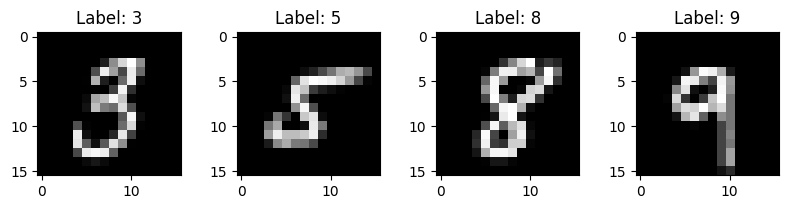

In [16]:
# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[0].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits

visualize_data(x_vis, y_vis)

In [17]:
x_perturb = x_perturb + perturbations

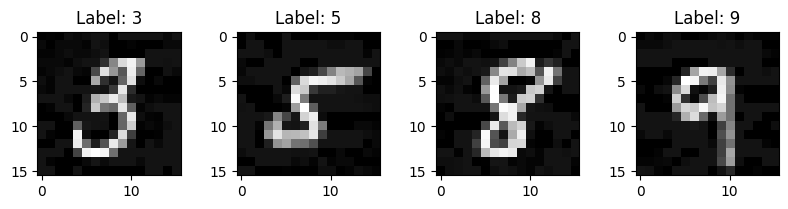

In [18]:
# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [(x_perturb[y_perturb == i])[0].squeeze(0).to("cpu") for i in range(len(digits))]
y_vis = digits

visualize_data(x_vis, y_vis)

In [19]:
adv_loader = DataLoader(TensorDataset(x_perturb, y_perturb), batch_size=batch_size)

In [20]:
test_loss, test_acc = test_loop(test_loader, neural_model, loss_fn, device)
adv_test_loss, adv_test_acc = test_loop(adv_loader, neural_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:5.2f}% | "
      f"Adv Test Loss: {adv_test_loss:.4f} | Adv Test Acc: {adv_test_acc*100:5.2f}% | ")

Test Loss: 0.1406 | Test Acc: 95.80% | Adv Test Loss: 0.4454 | Adv Test Acc: 85.50% | 


In [21]:
test_loss, test_acc = test_loop(test_loader, cnn_model, loss_fn, device)
adv_test_loss, adv_test_acc = test_loop(adv_loader, cnn_model, loss_fn, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:5.2f}% | "
      f"Adv Test Loss: {adv_test_loss:.4f} | Adv Test Acc: {adv_test_acc*100:5.2f}% | ")

Test Loss: 0.0553 | Test Acc: 98.25% | Adv Test Loss: 0.9604 | Adv Test Acc: 66.00% | 


In [22]:
# Evaluate model on adversarial examples
def evaluate_under_attack(model, base_feats, labels, epsilons, alpha, num_iter=10):
    acc_list = []

    for eps in epsilons:
        perturb = PGD(model, base_feats, labels, epsilon=eps, alpha=alpha, num_iter=num_iter)
        x_adv = (base_feats + perturb).clamp(0, 1)  # Clamp to valid pixel range
        adv_loader = DataLoader(TensorDataset(x_adv, labels), batch_size=batch_size)
        _, acc = test_loop(adv_loader, model, loss_fn, device)
        acc_list.append(acc)

    return acc_list

# Settings
epsilons = np.linspace(0, 0.2, 10)  # Change range/resolution as needed
x_perturb = x_test[:100].to(device)
y_perturb = y_test[:100].to(device)
alpha = 1e-2
num_iter = 100

# Evaluate both models
accs_cnn = evaluate_under_attack(cnn_model, x_perturb, y_perturb, epsilons, alpha, num_iter)
accs_neural = evaluate_under_attack(neural_model, x_perturb, y_perturb, epsilons, alpha, num_iter)

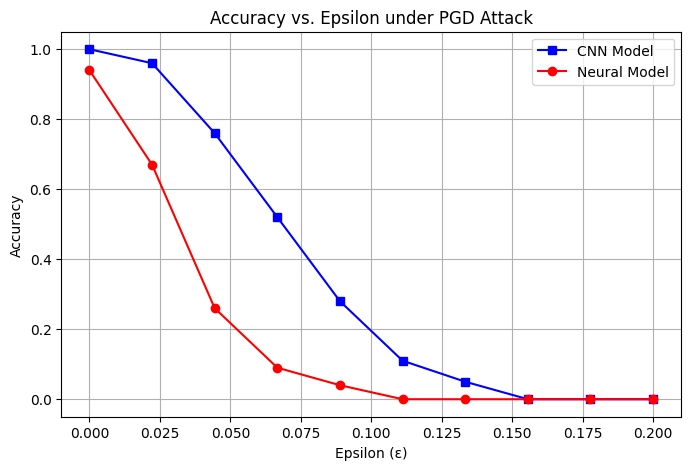

In [23]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accs_cnn, 'bs-', label='CNN Model')
plt.plot(epsilons, accs_neural, 'ro-', label='Neural Model')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon under PGD Attack')
plt.legend()
plt.grid(True)
plt.show()